In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 10.0)
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
from PIL import Image
from scipy.signal import convolve2d
from skimage.measure import block_reduce, find_contours
from matplotlib.patches import Rectangle
from kural_core.models import *
from kural_core.data_processing import *
from kural_core.functions import *
from kural_core.train_model import train_model
import pickle
from scipy.misc import imresize
from scipy.ndimage import morphology
from scipy.spatial import ConvexHull
from skimage import measure
from matplotlib import animation, rc
from IPython.display import HTML, display, clear_output
from os import listdir
from nd2reader import ND2Reader
from ipywidgets import widgets, Layout

PATH = r'D:\Code\kural_work\actin_gan_data\\'

In [2]:
with open(PATH+'he_le_tuple.pickle','rb') as f:
    he, le = pickle.load(f)

In [3]:
ds = ActinGanDataset(he, le)

In [4]:
with open(PATH+'good_high_and_low.pickle','rb') as f:
    good = pickle.load(f)
is_good = []
for i in range(good[0].shape[0]):
    is_good.append((good[0][i][None],good[1][i][None]))

In [23]:
def display_imgs():
    clear_output(wait=True)
    fig, ax = plt.subplots(1,2,figsize=(16,14))
    chance = 0
    while chance<0.5:
        idx = np.random.choice(len(ds))
        h,l = ds[idx]
        chance = nn.Softmax(1)(classifier_model((h.cuda()-mini)/(maxi-mini))).data.cpu().numpy()[0,1]
    m = ax[0].imshow(h[0,0])
    plt.colorbar(mappable=m, ax=ax[0],shrink=0.4)
    m = ax[1].imshow(l[0,0])
    plt.colorbar(mappable=m, ax=ax[1],shrink=0.4)
    plt.show()
    fig.subplots_adjust(wspace=0.01, hspace=0)
    
    def yes(btn):
        is_good.append((h.clone().detach().data,l.clone().detach().data))
        print('Was good!')
        display_imgs()
    def no(btn):
        print('Was not good!')
        display_imgs()
    y = widgets.Button(description='Yes, good')
    y.on_click(yes)
    n = widgets.Button(description='No, not good')
    n.on_click(no)
    w = widgets.HBox([y, n])
    display(w)

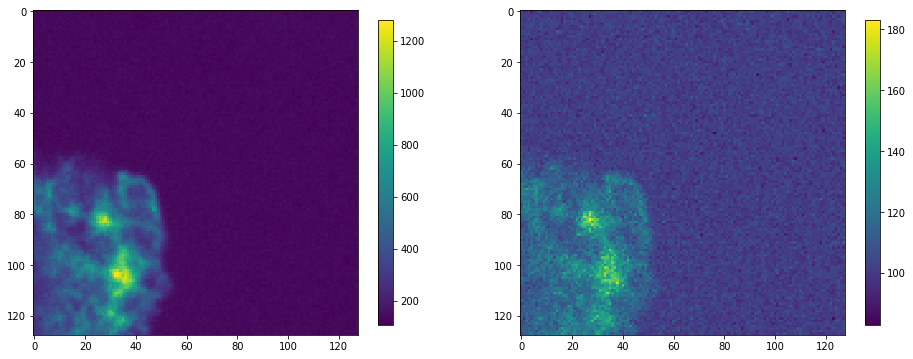

In [24]:
display_imgs()

In [27]:
good = (torch.cat([i for i,_ in is_good]),torch.cat([j for _,j in is_good]))
print(good[0].shape[0])
with open(PATH+'good_high_and_low.pickle','wb') as f:
    pickle.dump(good,f,protocol=4)

242


In [32]:
idx = np.random.choice(len(ds))
h,l = ds[idx]
print(h.shape)

torch.Size([1, 1, 128, 128])


In [5]:
classifier_model = ActinClassifierModel().cuda()

In [6]:
classifier_model.load_state_dict(torch.load(r'D:\Code\kural_work\actin_classifier_model.pth'))

In [7]:
classifier_model.eval()

ActinClassifierModel(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.05, inplace)
    (3): Sequential(
      (0): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.05, inplace)
    )
    (4): res_block(
      (conv): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.05, inplace)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.05, inplace)
 

In [61]:
nn.Softmax(1)(classifier_model((h.cuda()-mini)/(maxi-mini))).data.cpu().numpy()[0,1]

0.13346842

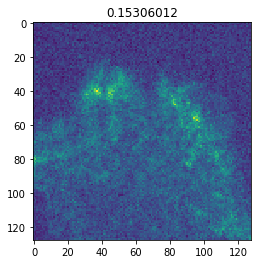

In [22]:
idx = np.random.choice(len(ds))
h,l = ds[idx]
chance = nn.Softmax(1)(classifier_model((h.cuda()-mini)/(maxi-mini))).data.cpu().numpy()[0,1]
plt.imshow(h[0,0])
plt.title(chance)
plt.show()

In [9]:
with open(PATH+'actin_classifier_model_image_normalization.pickle','rb') as f:
    mini, maxi = pickle.load(f)